In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# load data

reg_season = pd.read_csv('data/RegularSeasonDetailedResults.csv')
tourney = pd.read_csv('data/TourneyDetailedResults.csv')
ratings = pd.read_csv('data/addl/massey_ordinals_2003-2016.csv')
team_geog = pd.read_csv('data/addl/TeamGeog.csv')
tourney_geog = pd.read_csv('data/addl/TourneyGeog_Thru2016.csv')
tourney_slots = pd.read_csv('data/TourneySlots.csv')
tourney_seeds = pd.read_csv('data/TourneySeeds.csv')
kenpom = pd.read_csv('data/kenPomTeamData.csv')
teams = pd.read_csv('data/Teams.csv')
conferences = pd.read_csv('data/addl/TeamConferences_Thru2017.csv')

In [ ]:
# elo updating model -- account for elo differences, (crudely) home vs away, and win margin
# first play the season out once to seed the teams elo's
# reduce confidence of elo score, play the season out to get team elo features
# in playoffs, keep favored team at their elo, and set elo of underdog at next round assuming victory against top seed

In [313]:
season = 2016
rsc = reg_season[reg_season['Season'] == season].sort_values('Daynum')

elo_map = { team : 0 for team in set(rsc['Wteam']).union(rsc['Lteam']) }

hscores = rsc[rsc['Wloc'] == 'H']['Wscore'].tolist() + rsc[rsc['Wloc'] == 'A']['Lscore'].tolist()
ascores = rsc[rsc['Wloc'] == 'A']['Wscore'].tolist() + rsc[rsc['Wloc'] == 'H']['Lscore'].tolist()
correction = { 'H' : -(np.mean(hscores) - np.mean(ascores)), 'N' : 0, 'A' : np.mean(hscores) - np.mean(ascores) }

rsc['eff_score_diff'] = (rsc['Wscore'] - rsc['Lscore'] + rsc['Wloc'].map(lambda x: correction[x])).values

# decay time: how much history to consider?
# this can in theory be reduced during the tournament to emphasize recent performance
n_seed = 5
tau_seed = 50
tau_feature = 4
taus = [ tau_seed ] * n_seed + [ tau_feature ]
is_for_feature = [ False ] * n_seed + [ True ]

# seed the season -- run it a few times -- should over time bake in strength of schedule and converge 
win_elos, lose_elos = [], []
for tau, is_feature in zip(taus, is_for_feature):
    for wteam, lteam, effdiff in rsc[['Wteam', 'Lteam', 'eff_score_diff']].values:
        w_elo, l_elo = elo_map[wteam], elo_map[lteam]
        # store beginning of game status if it's time (i.e. done with elo seed)
        if is_feature:
            win_elos += [ w_elo ]
            lose_elos += [ l_elo ]
        # update elos
        source_elo_change = np.sign(effdiff) * np.log(1 + abs(effdiff)) 
        elo_map[wteam] = (l_elo + source_elo_change) / tau + (1 - 1/tau) * w_elo
        elo_map[lteam] = (w_elo - source_elo_change) / tau + (1 - 1/tau) * l_elo


rsc['Welo'] = win_elos
rsc['Lelo'] = lose_elos

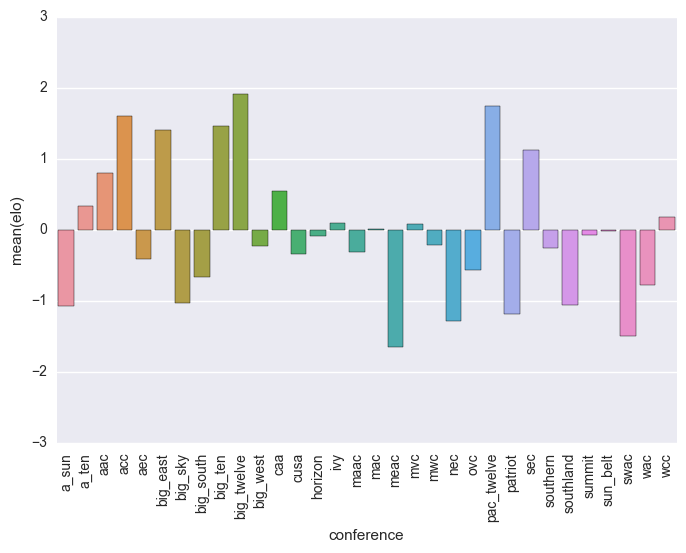

In [300]:
# check out how this breaks down by conference
# note this closely represents data seen in analyst conference websites like:
#     https://www.teamrankings.com/ncaa-basketball/rpi-ranking/rpi-rating-by-conf?date=2016-04-05
elodf = pd.DataFrame.from_dict(elo_map, orient = 'index').reset_index().rename(columns = {'index' : 'Team_Id', 0 : 'elo'})
cc = pd.merge(conferences[conferences['season'] == season], elodf, left_on = 'team_id', right_on = 'Team_Id')
bp = sns.barplot(data = cc, x = 'conference', y = 'elo', errwidth = 0)
plt.setp(bp.get_xticklabels(), rotation=90)
plt.show()

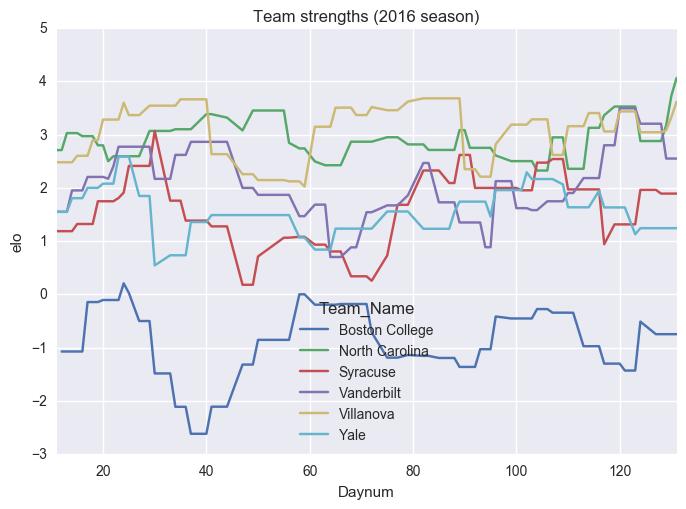

In [314]:
# track a few teams through time (ttt)
ttt = pd.concat([
    rsc[['Wteam', 'Welo', 'Daynum']].rename(columns = {'Wteam' : 'Team_Id', 'Welo' : 'elo'}),
    rsc[['Lteam', 'Lelo', 'Daynum']].rename(columns = {'Lteam' : 'Team_Id', 'Lelo' : 'elo'})
]).sort_values(['Team_Id', 'Daynum']).join(teams.set_index('Team_Id'), on = 'Team_Id')

teams_to_keep = ['Villanova', 'Syracuse', 'Boston College', 'Yale', 'Vanderbilt', 'North Carolina']
ttt = ttt[ttt['Team_Name'].isin(teams_to_keep)]

ttt_p = ttt.pivot(index = 'Daynum', columns = 'Team_Name', values = 'elo').fillna(method = 'ffill')

ttt_p.plot()
plt.ylabel('elo')
plt.title('Team strengths (' + str(season) +' season)')
plt.show()

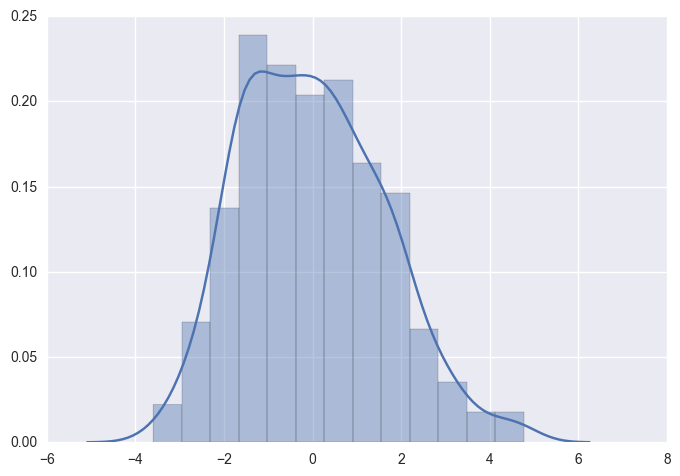

In [278]:
# elo distribution
sns.distplot(list(elo_map.values()))
plt.show()

higher momentum leading to wins (pct) --  0.7366362451108214


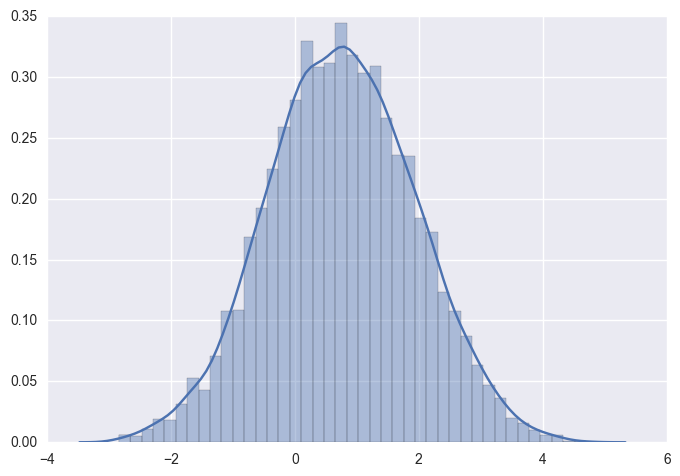

In [285]:
print('higher momentum leading to wins (pct) -- ', len([ x for x in (rsc['Welo'] - rsc['Lelo']) if x > 0 ]) / len(rsc))
sns.distplot(rsc['Welo'] - rsc['Lelo'])
plt.show()